In [1]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score,\
recall_score, confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
import pickle
import numpy as np


In [50]:
moodVec = pickle.load( open( "./moodVectors/MoodVecDes2.pickle", "rb" ))

In [51]:
#let's see structure of the moodVec
count = 0
for item in moodVec:
    print(moodVec[item])
    count = count + 1
print(count)

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (-1.0, 2), (1.0, 2), (-1.0, 2), (1.0, 2), (1.0, 2), (-0.5, 2), (0, 0), (-1.0, 2), (-1.0, 2), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (-1.0, 2), (1.0, 2), (0, 0), (1.0, 2), (0, 0), (0, 0), (-1.0, 2), (-0.5, 2), (0, 0), (-1.0, 2), (0, 0), (0, 0), (1.0, 2), (0, 0), (0, 0), (0, 0), (0.01, 2), (0, 0), (-1.0, 2), (1.0, 2), (1.0, 2), (0, 0), (0, 0), (1.0, 2), (0, 0), (0, 0), (0.5, 2), (1.0, 2), (0, 0), (0, 0), (1.0, 2), (0.01, 2), (0.5, 2), (1.0, 2), (1.0, 2), (1.0, 2), (0, 0), (1.0, 2), (0, 0), (0, 0), (0, 0)]
[(-0.16666666666666666, 2), (-0.25, 2), (-0.25, 2), (-0.8, 2), (-0.6, 2), (-0.2, 2), (0, 1), (0.5, 2), (-0.5, 2), (0, 0), (-1.0, 2), (-0.25, 2), (-0.5, 2), (1.0, 2), (1.0, 2), (1.0, 2), (1.0, 2), (1.0, 2), (-0.5, 2), (0.5, 2), (-1.0, 2), (-0.5, 2), (1.0, 2), (1.0, 2), (1.0, 2), (1.0, 2), (1.0, 2), (-0.6666666666666666, 2), (1.0, 2), (-1.0, 2), (-0.3333333333333333, 2), (-0.6666666666666666, 2), (-0.6666666666666666, 2), (-0.5, 2), (-0.5714285714

In [198]:
#reshape data from 3d to 2d
dataMatrix = np.array([moodVec[item] for item in moodVec.keys()])
print(dataMatrix.shape)
X = dataMatrix.reshape(74, 120)

(74, 60, 2)


In [200]:
# now you create a dataframe from dictionary, wow, so easy 
#moodVecDF = pd.DataFrame.from_dict(moodVec,  orient='index')

In [194]:
# you can get any length of vector like this
# X14 = np.concatenate((X[:,:14], X[:,61:75]),axis=1)
# X14.shape

(74, 28)

In [132]:
#merge with CESD
cesd = pd.read_csv('../important_data/adjustedCESD.csv')
cesdSum = cesd[['userid','cesd_sum']]
cesdSum  = cesdSum.drop_duplicates(subset='userid', keep="first")
#select CESD score with moodVec
cesdSum_subset = cesdSum[cesdSum['userid'].isin(moodVec.keys())]
#sort cesd index according to the dictionary key sequence 
cesdSum = cesdSum.set_index('userid')
sorted_CESD = cesdSum.loc[moodVec.keys()].reset_index()

It seems like the 14 days vector provide the best prediction result

In [168]:
y = sorted_CESD["cesd_sum"]
X = X[:,:14]
def recode(array):
    new = []
    for num in array:
        if num <= 23:
            new.append(0)
        if num > 23:
            new.append(1)
    return new
        
y = recode(y)
print(y.count(1))
print(y.count(0))

40
34


In [128]:
# parsed = {}
# for index, row in X.iterrows():
#     arr = []
#     for item in row:
#         item = item.replace('(', "")
#         item = item.replace(')', "")
#         a, b = item.split(',')
#         arr.append((float(a), float(b)))
#     parsed[index] = arr
# print(parsed)

In [129]:
# x2 = []
# for i in parsed:
#     print(parsed[i])
#     x2.append(parsed[i])

Don't scale it, all the features are on the same scale already

In [201]:
#SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 648)
cv = StratifiedKFold(n_splits=3, random_state = 0)
svc = make_pipeline(svm.SVC())
parameters = [{'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'svc__gamma': [0.5,0.1, 0.01,0.001, 0.0001],
                     'svc__C':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 10] , 'svc__class_weight':['balanced']}]

grid_search_item = GridSearchCV(svc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_searchSVC = grid_search_item.fit(X_train, y_train)

print(grid_searchSVC.best_score_)
print(grid_searchSVC.best_params_)

means = grid_searchSVC.cv_results_['mean_test_score']
stds = grid_searchSVC.cv_results_['std_test_score']
params = grid_searchSVC.cv_results_['params']

y_true, y_pred = y_test, grid_searchSVC.predict(X_test)
print(classification_report(y_true, y_pred))

0.5882352941176471
{'svc__C': 2.0, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.75      0.75      0.75        16

   micro avg       0.65      0.65      0.65        23
   macro avg       0.59      0.59      0.59        23
weighted avg       0.65      0.65      0.65        23



In [181]:
#SGD
clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter= 1000, random_state = 30))
parameters = [{'sgdclassifier__alpha': [0.001, 0.01, 0.05, 0.001, 0.005], 'sgdclassifier__class_weight':['balanced'],
              'sgdclassifier__loss': ['hinge','log','modified_huber','squared_hinge', 'perceptron'], 
               'sgdclassifier__penalty':['none','l1','l2']}]
grid_search_item = GridSearchCV(clf,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

0.6078431372549019
{'sgdclassifier__alpha': 0.01, 'sgdclassifier__class_weight': 'balanced', 'sgdclassifier__loss': 'perceptron', 'sgdclassifier__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.73      0.57      0.64        14

   micro avg       0.61      0.61      0.61        23
   macro avg       0.61      0.62      0.61        23
weighted avg       0.64      0.61      0.61        23



/home/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/lucia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [179]:
#boosting
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier()
parameters = [{'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]

grid_search_item = GridSearchCV(Ada,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))


0.5882352941176471
{'algorithm': 'SAMME', 'learning_rate': 1.5, 'n_estimators': 200, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.43      0.67      0.52         9
           1       0.67      0.43      0.52        14

   micro avg       0.52      0.52      0.52        23
   macro avg       0.55      0.55      0.52        23
weighted avg       0.57      0.52      0.52        23



/home/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [180]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
parameters = [{'max_depth': [1,2,3,4,5], 'n_estimators': [50,100,150,200],
                     'learning_rate':[1.0, 1.5, 2.0, 2.5, 3.0],'random_state':[100]}]
grid_search_item = GridSearchCV(gbc,
                          param_grid = parameters,
                           cv = cv,
                           scoring = 'accuracy',
                           n_jobs = -1)
grid_search = grid_search_item.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

0.6078431372549019
{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 100, 'random_state': 100}
              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       0.70      0.50      0.58        14

   micro avg       0.57      0.57      0.57        23
   macro avg       0.58      0.58      0.56        23
weighted avg       0.61      0.57      0.57        23



/home/lucia/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
#ensemble voting

estimators = []

model3 = svm.SVC(C = 10, kernel  = 'sigmoid', gamma =0.1,class_weight = 'balanced', random_state=300)
estimators.append(('svm', model3))
model2 = SGDClassifier(alpha = 0.001, class_weight = 'balanced', loss = 'hinge', penalty = 'l1', random_state = 2)
estimators.append(('logistic', model2))
# model1 = GradientBoostingClassifier(max_depth= 4, learning_rate= 1.0, n_estimators= 50, random_state= 100)
# estimators.append(('gbc', model1))
# model4 = AdaBoostClassifier(algorithm= 'SAMME', learning_rate= 2.0, n_estimators= 50, random_state= 100)
# estimators.append(('ada', model4))

ensemble = VotingClassifier(estimators)
eclf1 = ensemble.fit(X_train, y_train)
y_pred = eclf1.predict(X_test)
print('ROC is {}'. format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)


ROC is 0.5692307692307692
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.64      0.54      0.58        13

   micro avg       0.57      0.57      0.57        23
   macro avg       0.57      0.57      0.56        23
weighted avg       0.58      0.57      0.57        23



/Users/lucia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([[6, 4],
       [6, 7]])

Ensemble classfier won't work because the classifers in our case does not produce results that compensate each other, so we can adopt svm only

ROC AUC score A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

Here we use the SGD model

[0.         0.33333333 1.        ] [0.         0.57142857 1.        ] [2 1 0]


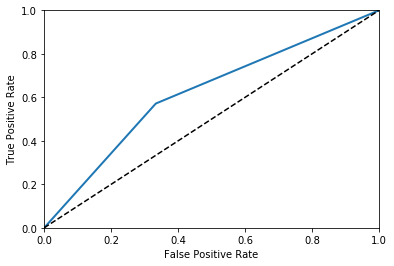

In [182]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
print(fpr, tpr, thresholds)
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr) 
plt.show()

In [183]:
print(y_true)
print(y_pred)

[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
[0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0]


In [184]:
#select cases in the test set
indexes = X_test.index.values
TestVal = ValCesd.loc[indexes]
TestVal['labels'] = y_test
TestVal['prelabels'] = y_pred

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
TestVal.to_csv('preEvaluate.csv')

Let's see what features the classifer capture

In [185]:
confusion_matrix(y_test, y_pred)

array([[6, 3],
       [6, 8]])

In [27]:
TestVal[1:5]

,userid,0,1,2,3,4,5,6,7,8,...,53,54,55,56,57,58,59,cesd_sum,labels,prelabels
14,db7f1b0130b2138e13b7bbca9cc63823,2,-1,2,-1,-1,2,1,2,-1,...,4,-1,-1,-1,1,-1,-1,14,0,0
29,a7a3af125074cb806a200f51ea7e10bf,2,2,-1,-1,-1,-1,-1,2,-1,...,-1,2,-1,-1,-1,-1,2,38,1,1
3,f49956142aab2ad74decfd49a103c2f1,-1,-1,-1,2,1,4,2,2,-1,...,4,4,-1,1,1,2,-1,21,0,1
5,f358b75c71d85c91ec0452c6114e3b15,-1,2,2,1,-1,2,-1,2,-1,...,2,-1,2,-1,-1,-1,-1,26,1,1


In [30]:
with open('./moodVectors/MoodVecDes1.pickle', 'rb') as handle:
    users = pickle.load(handle)

In [38]:
from collections import Counter
def DescribeUserVecTestSet(labelClass):
    highDep = []
    for userid, labels, prelabels in zip(TestVal['userid'],TestVal['labels'],TestVal['prelabels']):
    #     print(userid, labels, prelabels)
        if prelabels == labelClass:
            highDep.append(userid)

    for userid in highDep:
        print('user {} has {} empty days, {} negative days, {} positive days and {} neutral days'.format(userid, users[userid].count(-1), users[userid].count(1), users[userid].count(2), users[userid].count(4)))
    
    
#Here we see the prediction labels: high group vectors
DescribeUserVecTestSet(1)

user 1789589a6d2bba0f09d768f8f3445be5 has 30 empty days, 18 negative days, 8 positive days and 4 neutral days
user a7a3af125074cb806a200f51ea7e10bf has 37 empty days, 0 negative days, 22 positive days and 1 neutral days
user f49956142aab2ad74decfd49a103c2f1 has 29 empty days, 11 negative days, 13 positive days and 7 neutral days
user f358b75c71d85c91ec0452c6114e3b15 has 28 empty days, 7 negative days, 20 positive days and 3 neutral days
user 5c31d7d80e78643cd5289acec0561d77 has 43 empty days, 8 negative days, 5 positive days and 4 neutral days
user 8c393982479748c5a53acaa7a3717c71 has 4 empty days, 35 negative days, 16 positive days and 0 neutral days
user e076953cd3fcf8927b8f21574c0890f3 has 27 empty days, 9 negative days, 16 positive days and 7 neutral days
user 088bf0ed841bcc366475b3975eb1b9d2 has 37 empty days, 11 negative days, 10 positive days and 2 neutral days
user 4104c0b8700d519d1661c8a59b065363 has 35 empty days, 9 negative days, 8 positive days and 7 neutral days
user 19316

In [33]:
TestVal['labels'] = y_test
def DescribeUserVecTestSet(labelClass):
    highDep = []
    for userid, labels, prelabels in zip(TestVal['userid'],TestVal['labels'],TestVal['prelabels']):
    #     print(userid, labels, prelabels)
        if labels == labelClass:
            highDep.append(userid)

    for userid in highDep:
        print('user {} has {} empty days, {} negative days, {} positive days and {} neutral days'.format(userid, users[userid].count(-1), users[userid].count(1), users[userid].count(2), users[userid].count(4)))
    

#Here we see the prediction labels: high group vectors


In [34]:
#high group
DescribeUserVecTestSet(1)

user 1789589a6d2bba0f09d768f8f3445be5 has 30 empty days, 18 negative days, 8 positive days and 4 neutral days
user a7a3af125074cb806a200f51ea7e10bf has 37 empty days, 0 negative days, 22 positive days and 1 neutral days
user f358b75c71d85c91ec0452c6114e3b15 has 28 empty days, 7 negative days, 20 positive days and 3 neutral days
user 5c31d7d80e78643cd5289acec0561d77 has 43 empty days, 8 negative days, 5 positive days and 4 neutral days
user 3e6f69fc89da71e8237c717ac218677b has 42 empty days, 10 negative days, 5 positive days and 3 neutral days
user 8c393982479748c5a53acaa7a3717c71 has 4 empty days, 35 negative days, 16 positive days and 0 neutral days
user e076953cd3fcf8927b8f21574c0890f3 has 27 empty days, 9 negative days, 16 positive days and 7 neutral days
user 088bf0ed841bcc366475b3975eb1b9d2 has 37 empty days, 11 negative days, 10 positive days and 2 neutral days
user 0b12516100c16f779b152858619786ff has 24 empty days, 15 negative days, 19 positive days and 2 neutral days
user 4104

In [35]:
#low group
DescribeUserVecTestSet(0)

user db7f1b0130b2138e13b7bbca9cc63823 has 28 empty days, 14 negative days, 11 positive days and 7 neutral days
user f49956142aab2ad74decfd49a103c2f1 has 29 empty days, 11 negative days, 13 positive days and 7 neutral days
user aed86a3085a364f5484679649f064467 has 30 empty days, 6 negative days, 18 positive days and 6 neutral days
user 66495ec54feb9e2399db05a67a80f2c6 has 37 empty days, 4 negative days, 18 positive days and 0 neutral days
user 4764518d32334248e6ebbf681a18fd0c has 12 empty days, 28 negative days, 14 positive days and 4 neutral days
user 193165601dfad67e79ef52b2caf9fd9e has 43 empty days, 6 negative days, 10 positive days and 0 neutral days
user cea00424ced413c108d878b1a14f3316 has 29 empty days, 6 negative days, 17 positive days and 8 neutral days
user 8b6ceafaf2ea6bd34f26ff463156363c has 39 empty days, 7 negative days, 13 positive days and 1 neutral days
--------here shows the stats for label class-----------------


In the test set, we can see that people in the high group are indeed have more positive days and less empty days in general, the classifer capture the right information

In [37]:
ValCesd['biLabel'] = y
ValCesd.describe()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,cesd_sum,biLabel
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.459459,0.662162,0.405405,0.405405,0.648649,0.567568,0.756757,0.554054,0.635135,0.864865,...,0.594595,0.391892,0.621622,0.851351,0.310811,0.310811,0.256757,0.364865,24.094595,0.540541
std,1.563182,1.657503,1.560812,1.423087,1.591350,1.553441,1.653645,1.518307,1.724714,1.616052,...,1.703493,1.694613,1.585056,1.669078,1.403769,1.451741,1.414802,1.635014,11.863573,0.501756
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,15.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,25.000000,1.000000
75%,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,33.000000,1.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,48.000000,1.000000
